# Conditional GAN (CGAN)

## Theory

An important extension to the GAN is in their use for conditionally generating an output.

The conditional generative adversarial network, or cGAN for short, is an extension to the GAN architecture that makes use of information in addition to the image as input both to the generator and the discriminator models. For example, if class labels are available, they can be used as input.

**The models are trained together in a zero-sum or adversarial manner, such that improvements in the discriminator come at the cost of a reduced capability of the generator, and vice versa.**

The generative model can be trained to generate new examples from the input domain, where the input, the random vector from the latent space, is provided with (conditioned by) some additional input.

The additional input could be a class value, such as male or female in the generation of photographs of people, or a digit, in the case of generating images of handwritten digits.

The discriminator is also conditioned, meaning that it is provided both with an input image that is either real or fake and the additional input. In the case of a classification label type conditional input, the discriminator would then expect that the input would be of that class, in turn teaching the generator to generate examples of that class in order to fool the discriminator.

**There are many ways to encode and incorporate the class labels into the discriminator and generator models. A best practice involves using an embedding layer followed by a fully connected layer with a linear activation that scales the embedding to the size of the image before concatenating it in the model as an additional channel or feature map.**

In this way, a conditional GAN can be used to generate examples from a domain of a given type.

Taken one step further, the GAN models can be conditioned on an example from the domain, such as an image. This allows for applications of GANs such as text-to-image translation, or image-to-image translation. This allows for some of the more impressive applications of GANs, such as style transfer, photo colorization, transforming photos from summer to winter or day to night, and so on.

In the case of conditional GANs for image-to-image translation, such as transforming day to night, the discriminator is provided examples of real and generated nighttime photos as well as (conditioned on) real daytime photos as input. The generator is provided with a random vector from the latent space as well as (conditioned on) real daytime photos as input.

$$\min_G \max_D V(D, G) = \mathbb{E}_{\mathbf{x} \sim p_{data}(\mathbf{x})} [\log D(\mathbf{x}, \mathbf{y})] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [\log (1 - D(G(\mathbf{z}, \mathbf{y}), \mathbf{y}))]$$

+ Recall, in GAN, we have two neural nets: the generator $G(z)$ and the discriminator $D(x)$. Now, as we want to condition those networks with some vector $y$, the easiest way to do it is to feed $y$ into both networks. Hence, our generator and discriminator are now $G(z, y)$ and $D(x, y)$ respectively.

+ The conditional variables for CGAN could be anything.


## Advantages and Limitations


## References

M. Mirza and S. Osindero, Conditional Generative Adversarial Nets, 2014.

J. Gauthier, Conditional generative adversarial nets for convolutional face generation, 2015.

E. Denton, et al., Deep Generative Image Models using a Laplacian Pyramid of Adversarial Networks, NIPS 2015.

P. Isola, J.-Y. Zhu, T. Zhou and A. A. Efros, Image-to-Image Translation with Conditional Adversarial Networks, CVPR 2017.

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
Z_dim = 100
h_dim = 128

+ Initialization

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

+ Latent variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $G$ and Discriminator $D$ are two networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, Two-Layer Full-Connected Forward Feedback NN.

+ The problem we have here is how to incorporate the new variable $y$ into $D(x)$ and $G(z)$. As we are trying to model the joint conditional, the simplest way to do it is to just concatenate both variables. Hence, in $G(z, y)$, we are concatenating $z$ and $y$ before we feed it into the networks. The same procedure is applied to $D(x, y)$.

In [7]:
def generator(z, y):
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

def discriminator(x, y):
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
G_sample = generator(Z, y)

D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

+ Loss functions

In [10]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


+ Here, $k = 1$

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-CGAN/'):
    os.makedirs('GAN-CGAN/')

avg_costs = {'discriminator': [], 'generator': []}

i = 0

for it in range(50000):
    X_mb, y_mb = mnist.train.next_batch(mb_size)
    Z_sample = sample_Z(mb_size, Z_dim)
    
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('\n')
        
        n_sample = 16
        
        Z_sample = sample_Z(n_sample, Z_dim)
        # Create conditional one-hot vector, with index 7 = 1
        y_sample = np.zeros(shape=[n_sample, y_dim])
        y_sample[:, 7] = 1
        
        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y: y_sample})

        fig = plot(samples)
        plt.savefig('GAN-CGAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['discriminator'].append(D_loss_curr / n_sample)
        avg_costs['generator'].append(G_loss_curr / n_sample)

Iter: 0
D_loss: 1.152
G_loss: 3.013


Iter: 1000
D_loss: 0.01284
G_loss: 7.911


Iter: 2000
D_loss: 0.038
G_loss: 5.726


Iter: 3000
D_loss: 0.1473
G_loss: 5.618


Iter: 4000
D_loss: 0.1343
G_loss: 5.307


Iter: 5000
D_loss: 0.09694
G_loss: 5.345


Iter: 6000
D_loss: 0.4713
G_loss: 4.56


Iter: 7000
D_loss: 0.7428
G_loss: 3.032


Iter: 8000
D_loss: 0.7555
G_loss: 3.884


Iter: 9000
D_loss: 0.6527
G_loss: 2.94


Iter: 10000
D_loss: 0.6867
G_loss: 3.095


Iter: 11000
D_loss: 0.9447
G_loss: 2.597


Iter: 12000
D_loss: 0.7265
G_loss: 2.558


Iter: 13000
D_loss: 0.7116
G_loss: 2.316


Iter: 14000
D_loss: 1.14
G_loss: 1.882


Iter: 15000
D_loss: 0.7245
G_loss: 2.693


Iter: 16000
D_loss: 0.8748
G_loss: 1.961


Iter: 17000
D_loss: 0.7282
G_loss: 2.047


Iter: 18000
D_loss: 0.9443
G_loss: 1.812


Iter: 19000
D_loss: 0.7969
G_loss: 2.073


Iter: 20000
D_loss: 0.8892
G_loss: 1.806


Iter: 21000
D_loss: 0.8892
G_loss: 1.975


Iter: 22000
D_loss: 1.037
G_loss: 1.841


Iter: 23000
D_loss: 0.8326
G_

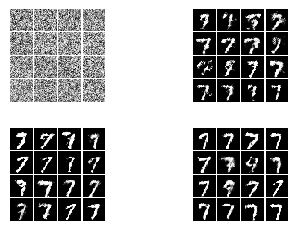

In [14]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-CGAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-CGAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-CGAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-CGAN/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

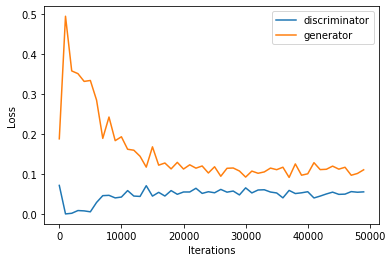

In [15]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['discriminator']))*1000, avg_costs['discriminator'], label='discriminator')
plt.plot(np.arange(len(avg_costs['generator']))*1000, avg_costs['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()